# 와린이를 위한 추천 시스템
-사용자의 선호도 (분위기, 과일향, 음식취향 등) 선택 시, 와인 리뷰 텍스트의 유사도가 높은 와인을 추천

- dataset : https://www.kaggle.com/datasets/zynicide/wine-reviews?select=winemag-data_first150k.csv

- 회귀 기반 추천 시스템

- **컬럼 명**<br>
Unnamed: 0 : 아이디 번호 <br>
country : 나라 이름<br>
**description : 리뷰**<br>
designation : 와인의 고유 특성<br>
points : 점수<br>
price : 가격<br>
province : 와인 생산 지역<br>
region_1 : 와인 생산 세부 지역 1<br>
region_2 : 와인 생산 세부 지역 2<br>
taster_name : 리뷰 작성자 이름<br>
taster_twitter_handle : 리뷰 작성자 트위터 아이디<br> 
**title : 와인 이름**<br> 
variety : 와인 종류<br> 
winery : 와이너리(양조장)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## EDA 

In [2]:
wine = pd.read_csv('./data/archive/winemag-data-130k-v2.csv')
print(wine.shape)
wine.head()


(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
wine.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
# NaN 값 데이터(열) 삭제
columns = ['country', 'variety']
wine = wine.dropna(subset=columns)

# 수치형 결측치 값은 각 컬럼의 평균을 집어넣는다.
wine_price_mean = wine['price'].mean()
wine['price'] = wine['price'].fillna(wine_price_mean)

# 세부 지역 결측치는 나라이름을 집어넣는다.
wine['region_1'] = wine['region_1'].fillna(wine['country'])
wine['region_2'] = wine['region_2'].fillna(wine['country'])

# 컬럼 삭제
columns = ['Unnamed: 0', 'taster_name', 'taster_twitter_handle']
wine = wine.drop(columns, axis = 1)

wine.info()


<class 'pandas.core.frame.DataFrame'>
Index: 129907 entries, 0 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129907 non-null  object 
 1   description  129907 non-null  object 
 2   designation  92454 non-null   object 
 3   points       129907 non-null  int64  
 4   price        129907 non-null  float64
 5   province     129907 non-null  object 
 6   region_1     129907 non-null  object 
 7   region_2     129907 non-null  object 
 8   title        129907 non-null  object 
 9   variety      129907 non-null  object 
 10  winery       129907 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 11.9+ MB


## NLTK

In [5]:
# !conda install nltk -y

In [6]:
import nltk
import string
nltk.__version__

'3.9.1'

### TfidfVectorizer

In [7]:
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    """
    소문자변환, 특수문자제거, 토큰화, 어근분리
    """
    # 1. 소문자 변환
    text = text.lower() 
    
    # 2. 특수문자 변환표 dict
    punc_rem_dict = dict((ord(ch), None) for ch in string.punctuation)
    text = text.translate(punc_rem_dict) # 특수문자 제거  
    
    # 3. 토큰화 
    tokens = nltk.word_tokenize(text)
    
    # 4. 어근분리 
    lemmatizer = WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lemmatize,
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 0.9,
    min_df = 0.05
)
review_vecs = tfidf_vectorizer.fit_transform(wine['description'])
print(review_vecs.toarray().shape)  # 밀집행렬
print(review_vecs)  # 희소행렬


C:\Users\playdata2\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\playdata2\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(


(129907, 66)
  (0, 0)	0.2571630954552682
  (0, 15)	0.38257331305450776
  (0, 2)	0.37435384685908346
  (0, 39)	0.3428802537550379
  (0, 41)	0.24730368069891837
  (0, 20)	0.6045724421087649
  (0, 26)	0.21107500736732845
  (0, 3)	0.24202794140624023
  (1, 5)	0.29290629907015486
  (1, 47)	0.29018057382470824
  (1, 31)	0.3436938588772809
  (1, 58)	0.23547874447226164
  (1, 23)	0.3500044393014061
  (1, 56)	0.31960775307409817
  (1, 52)	0.37131142811479867
  (1, 64)	0.16445965229369147
  (1, 27)	0.347043074720365
  (1, 49)	0.25118567061738467
  (1, 0)	0.22312090165555795
  (1, 26)	0.1831337652759891
  (2, 17)	0.49752461110350044
  (2, 29)	0.5554128960268149
  (2, 24)	0.5065468890072841
  (2, 64)	0.25684693174143297
  (2, 0)	0.3484618762009285
  :	:
  (129904, 12)	0.35076888884770524
  (129904, 19)	0.22133095615196494
  (129904, 54)	0.25870035037678835
  (129904, 17)	0.3104788566380807
  (129904, 56)	0.31149406891649856
  (129904, 64)	0.32056923383631264
  (129904, 27)	0.33823290703738496
  (1

In [9]:
# 66개의 단어 
tfidf_vectorizer.vocabulary_


{'aromas': 3,
 'fruit': 26,
 'dry': 20,
 'palate': 41,
 'offer': 39,
 'apple': 2,
 'citrus': 15,
 'acidity': 0,
 'ripe': 49,
 'fruity': 27,
 'wine': 64,
 'smooth': 52,
 'structure': 56,
 'firm': 23,
 'tannins': 58,
 'juicy': 31,
 'red': 47,
 'berry': 5,
 'flavor': 24,
 'green': 29,
 'crisp': 17,
 'lemon': 33,
 'note': 37,
 'finish': 22,
 'come': 16,
 'good': 28,
 'blackberry': 8,
 'raspberry': 46,
 'spicy': 55,
 'dark': 18,
 'plum': 45,
 'fresh': 25,
 'bright': 10,
 'open': 40,
 'white': 63,
 'pepper': 44,
 'balance': 4,
 'soft': 53,
 'spice': 54,
 'texture': 59,
 'peach': 42,
 'pear': 43,
 'touch': 61,
 'drink': 19,
 'cabernet': 11,
 'chocolate': 14,
 'character': 12,
 'rich': 48,
 'black': 6,
 'cherry': 13,
 'oak': 38,
 'black cherry': 7,
 'vanilla': 62,
 'years': 65,
 'feel': 21,
 'nose': 36,
 'blend': 9,
 'sauvignon': 51,
 'toast': 60,
 'hint': 30,
 'lead': 32,
 'round': 50,
 'light': 34,
 'make': 35,
 'sweet': 57,
 'age': 1}

| 영어        | 한국어 설명                                  |
|-------------|---------------------------------------------|
| aromas      | 향, 와인의 향기                              |
| fruit       | 과일, 와인의 과일 풍미                       |
| dry         | 드라이한, 단맛이 없는 와인                   |
| palate      | 입안에서 느껴지는 맛과 질감                  |
| offer       | 제시하다, 와인에서 특정 풍미를 느낄 수 있음    |
| apple       | 사과와 같은 과일 풍미                        |
| citrus      | 시트러스와 같은 과일 풍미                    |
| lemon       | 레몬과 같은 과일 풍미                        |
| peach       | 복숭아와 같은 과일 풍미                      |
| pear        | 배와 같은 과일 풍미                          |
| acidity     | 산도, 신맛의 정도                            |
| ripe        | 잘 익은, 과일 맛이 충분히 성숙한 상태        |
| fruity      | 과일 풍미가 풍부한                           |
| wine        | 와인 자체                                   |
| smooth      | 부드러운, 입안에서 매끄러운 느낌            |
| structure   | 구조감, 와인의 균형과 구성                   |
| firm        | 탄탄한, 구조가 강한                         |
| tannins     | 타닌, 떫은맛을 내는 성분                    |
| juicy       | 과즙이 풍부한 느낌                           |
| red         | 적색 와인                                   |
| white       | 백색 와인                                   |
| berry       | 베리류 풍미                                 |
| blackberry  | 블랙베리 같은 풍미                           |
| raspberry   | 라즈베리 같은 풍미                           |
| black cherry| 블랙 체리 같은 풍미                          |
| flavor      | 풍미, 맛                                    |
| green       | 풋내, 덜 익은 과일 같은 풍미                |
| crisp       | 상쾌한, 산뜻한 맛                           |
| finish      | 마무리, 와인이 입안에서 남는 여운           |
| good        | 좋은 품질을 나타냄                          |
| spicy       | 향신료 풍미                                 |
| spice       | 향신료 풍미                                 |
| dark        | 깊고 진한 느낌                              |
| plum        | 자두 같은 풍미                              |
| fresh       | 신선한                                      |
| bright      | 생동감 있고 활기찬 느낌                     |
| smooth      | 부드러운                                    |
| soft        | 부드러운 질감                               |
| texture     | 와인의 질감                                 |
| touch       | 가벼운 느낌으로 존재하는 맛                 |
| drink       | 마실 준비가 된 상태                         |
| cabernet    | 카베르네 품종                               |
| sauvignon   | 소비뇽 품종                                 |
| chocolate   | 초콜릿 풍미                                 |
| character   | 독특한 성격                                 |
| rich        | 풍부한                                      |
| oak         | 오크통 숙성으로 생긴 풍미                   |
| vanilla     | 바닐라 풍미                                 |
| years       | 숙성에 걸리는 기간                          |
| feel        | 와인에서 느껴지는 감각                      |
| nose        | 와인의 향을 맡았을 때의 느낌                |
| blend       | 블렌딩 와인, 여러 포도 품종이 섞인 것       |
| toast       | 구운 듯한 풍미                              |
| hint        | 미묘한 풍미                                 |
| lead        | 주도하는 맛                                 |
| round       | 둥글고 부드러운 느낌                        |
| light       | 가벼운 와인                                 |
| make        | 특정한 특징을 만들어내는 과정               |
| sweet       | 단맛                                        |
| age         | 숙성                                        |


**선택지**<br>
[선택1] 더 선호하는 과일은 무엇입니까?<br>
    1. 상큼.. 2. 달달.. 3. 초콜릿 4. 시트러스 5. 향신료<br>
[선택2] 어떤 종류의 음식과 마실 예정입니까??<br>
    1. 육류 2. 생선 3. 채소<br>
[선택3] 어떤 분위기에서 마실 예정입니까?<br>
    1. 특별한 기념일 2. 가벼운 자리 3. 신나는 파티

In [24]:
words = []

step1 = input('''
>> 더 선호하는 과일은 무엇입니까? 
1. 상큼한 레몬..
2. 달달한 베리류..
3. 초콜릿..
4. 시트러스..
5. 향신료
''')

match choice :
    case '1':
        fruit =['lemon']
        words.append(fruit)

print(words)

3


## KMeans 군집화

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters = 10,
    max_iter = 10000,
    random_state = 0
)
# 중심점 게산
reviews_label = kmeans.fit_predict(review_vecs)
wine['cluster'] = reviews_label
wine.head()


,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,cluster
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.368796,Sicily & Sardinia,Etna,Italy,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,5
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Portugal,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,8
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,6
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,US,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,4
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,7


In [11]:
wine['variety'].nunique()

701

In [18]:
# 군집화 중심점


centers = kmeans.cluster_centers_
centers.shape # (클러스터 개수, 단어개수)


(10, 66)

In [22]:
# tf-idf값이 높은 순으로 정렬
centroid_arg_ind = centers.argsort()[:, ::-1]
top20 = centroid_arg_ind[:, :30]
feature_names = tfidf_vectorizer.get_feature_names_out()
display(feature_names[top20])

top20_df = pd.DataFrame(feature_names[top20])
display(top20_df)

array([['black', 'black cherry', 'cherry', 'tannins', 'palate', 'pepper',
        'aromas', 'flavor', 'fruit', 'wine', 'spice', 'plum',
        'blackberry', 'finish', 'offer', 'dark', 'note', 'nose', 'dry',
        'drink', 'ripe', 'red', 'chocolate', 'firm', 'raspberry', 'open',
        'structure', 'berry', 'make', 'hint'],
       ['berry', 'aromas', 'flavor', 'finish', 'palate', 'red',
        'tannins', 'spice', 'plum', 'note', 'fruit', 'cherry', 'wine',
        'feel', 'drink', 'offer', 'acidity', 'nose', 'dry', 'bright',
        'ripe', 'dark', 'fresh', 'raspberry', 'open', 'pepper',
        'chocolate', 'hint', 'blend', 'juicy'],
       ['cabernet', 'sauvignon', 'blend', 'flavor', 'tannins',
        'blackberry', 'wine', 'fruit', 'black', 'cherry', 'finish',
        'aromas', 'dry', 'red', 'drink', 'spice', 'chocolate', 'note',
        'make', 'palate', 'dark', 'plum', 'ripe', 'rich', 'oak', 'soft',
        'offer', 'structure', 'balance', 'years'],
       ['peach', 'white', 'c

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,black,black cherry,cherry,tannins,palate,pepper,aromas,flavor,fruit,wine,...,ripe,red,chocolate,firm,raspberry,open,structure,berry,make,hint
1,berry,aromas,flavor,finish,palate,red,tannins,spice,plum,note,...,ripe,dark,fresh,raspberry,open,pepper,chocolate,hint,blend,juicy
2,cabernet,sauvignon,blend,flavor,tannins,blackberry,wine,fruit,black,cherry,...,dark,plum,ripe,rich,oak,soft,offer,structure,balance,years
3,peach,white,citrus,flavor,finish,palate,aromas,fruit,wine,note,...,make,green,bright,balance,drink,light,touch,feel,blend,open
4,lemon,palate,flavor,apple,wine,acidity,finish,nose,fresh,note,...,offer,hint,drink,ripe,make,green,light,balance,texture,rich
5,apple,pear,flavor,palate,green,finish,aromas,acidity,citrus,wine,...,hint,drink,light,balance,touch,bright,toast,make,feel,round
6,wine,crisp,acidity,fruity,light,drink,fresh,fruit,flavor,texture,...,finish,blend,spice,tannins,good,round,rich,juicy,green,hint
7,flavor,finish,aromas,cherry,fruit,palate,wine,note,spice,dry,...,vanilla,make,acidity,dark,chocolate,blend,ripe,feel,hint,light
8,wine,fruit,age,ripe,drink,tannins,rich,structure,acidity,character,...,red,soft,smooth,blackberry,come,good,make,round,blend,berry
9,oak,flavor,wine,fruit,finish,blackberry,vanilla,toast,cherry,tannins,...,acidity,make,black,years,soft,chocolate,good,offer,red,raspberry


In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. 데이터 차원 축소 (여기서는 t-SNE 사용, 데이터에 따라 PCA도 가능)
reduced_data = TSNE(n_components=2, random_state=42).fit_transform(wine['cluster'])

# 2. 시각화
plt.figure(figsize=(10, 7))

# 각 클러스터에 해당하는 포인트들 표시
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=10, alpha=0.5, label='Data Points')

# 클러스터 중심점(centers) 차원 축소하여 표시
reduced_centers = TSNE(n_components=2, random_state=42).fit_transform(centers)
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', s=100, marker='x', label='Cluster Centers')

plt.legend()
plt.title("Clustering Result Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [12]:
# 클러스터별 샘플 확인
wine[wine['cluster'] == ]


,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,cluster


In [14]:
# 와인 이름 관련 리뷰를 기준 리뷰로 선정
douro_index = wine[wine['cluster'] == 24].index
print(douro_index.shape)  # (1155,)
print(douro_index[:5])

# 첫번째 리뷰를 기준리뷰로 선정
base_index = 1
wine.iloc[base_index]


(0,)
Index([], dtype='int64')


country                                                 Portugal
description    This is ripe and fruity, a wine that is smooth...
designation                                             Avidagos
points                                                        87
price                                                       15.0
province                                                   Douro
region_1                                                Portugal
region_2                                                Portugal
title              Quinta dos Avidagos 2011 Avidagos Red (Douro)
variety                                           Portuguese Red
winery                                       Quinta dos Avidagos
cluster                                                        8
Name: 1, dtype: object

In [15]:
# 기준 리뷰와 모든 리뷰의 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

print(review_vecs[base_index].shape, review_vecs.shape)  # (1, 66) (129907, 66)

review_sim = cosine_similarity(review_vecs[base_index], review_vecs)
print(review_sim.shape)


(1, 66) (129907, 66)
(1, 129907)


In [16]:
# 유사도가 높은 순으로 정렬
review_sorted_index = review_sim.argsort()[:, ::-1]  # 내림차순 정렬
review_sorted_index = review_sorted_index[:, 1:]
review_sorted_index = review_sorted_index.reshape(-1)  # 자기자신 제외
print(review_sorted_index.shape)

# 유사도가 높은 순으로 정렬된 와인 이름 조회
result_df = wine.iloc[review_sorted_index][['title', 'cluster']]
review_sim = review_sim.reshape(-1)
result_df['similarity'] = review_sim[review_sorted_index]
result_df


(129906,)


,title,cluster,similarity
71098,Château Crusquet Sabourin 2015 Blaye Côtes de...,8,0.815368
41549,Château Crusquet Sabourin 2015 Blaye Côtes de...,8,0.815368
69572,Château Fondarzac 2012 Bordeaux Supérieur,8,0.798636
86958,Mas de Gourgonnier 2007 Red (Les Baux de Prove...,8,0.783510
31174,Vignoble de la Jarnoterie 2012 Concerto (Sain...,8,0.776358
...,...,...,...
90992,La Fenêtre 2007 Calmant Creek Vineyard Pinot N...,7,0.000000
90995,Gérard Bertrand 2006 Réserve Spéciale Pinot No...,7,0.000000
90998,Le Bonheur 2007 Chardonnay (Simonsberg-Stellen...,9,0.000000
91001,Viña Mar de Casablanca 2008 Reserva Sauvignon ...,3,0.000000


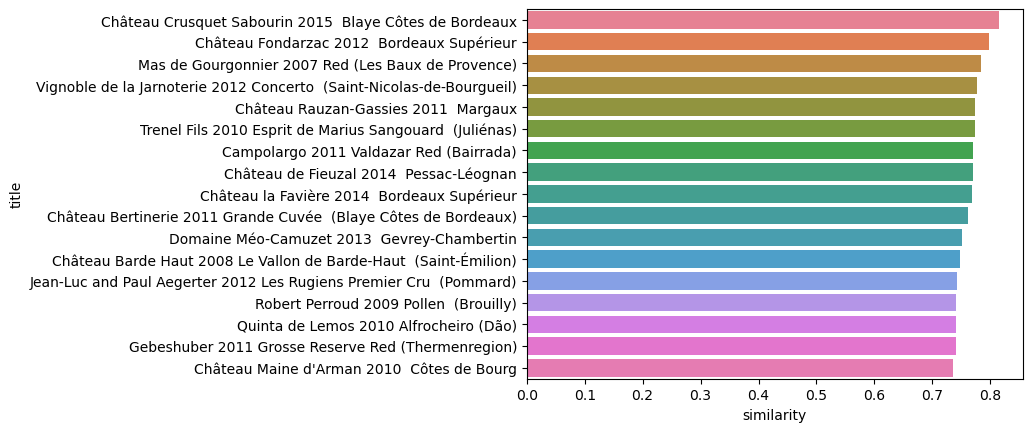

In [15]:
sns.barplot(x = 'similarity', y = 'title', data = result_df.iloc[:20], hue = 'title')

plt.show()